# DQN

Mikhail Papkov, 17.06.2018

-----------------

Here we will train the original DQN model on our Pommerman data and compare results with the imitation pre-training and without it

DQN paper: https://www.nature.com/articles/nature14236.pdf

Pre-training paper: https://arxiv.org/pdf/1709.04083.pdf

In [30]:
import os
import sys
import time
import numpy as np

# GPU specifications
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"]="7"

sys.path.append('/path/to/pommerman/playground/')
sys.path.append('/path/to/evaluation_utils.py/')

In [61]:
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers import Input, Dense, Flatten, Conv2D, Conv3D, BatchNormalization, Activation, Add
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from keras.optimizers import Adadelta, Adam
from keras import backend as K

import warnings
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Env, Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, Callback

from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent
from pommerman.configs import ffa_v0_fast_env as ffa_v0_env
from pommerman.configs import ffa_v0_fast_env 
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility
from pommerman.constants import *

from tqdm import tqdm_notebook as tqdm

In [ ]:
from evaluation_utils import *

In [3]:
view_size = BOARD_SIZE * 2 - 1  # 21
history_length = 4
n_channels = 18
ACTIONS = ['stop', 'up', 'down', 'left', 'right', 'bomb']

In [4]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


### Data for the pre-training

In [5]:
train_data_path = './dataset/'
train_data_obs = os.path.join(train_data_path, 'obs.npy')
train_data_labels = os.path.join(train_data_path, 'labels.npy')
train_data_reward = os.path.join(train_data_path, 'reward.npy')
train_data_obs_map_history = os.path.join(train_data_path, 'obs_map_history.npy')

In [19]:
if os.path.isdir(train_data_path):
    observations = np.load(train_data_obs_map_history)
    labels = np.load(train_data_labels)
    labels = to_categorical(labels, env.action_space.n)
    print('Loaded')
else:
    assert False

observations.shape

Loaded


(670725, 4, 21, 21, 18)

Concatenate time steps to the channel dimension

In [20]:
observations = np.array([np.concatenate(obs, axis=-1) for obs in observations])
observations.shape

(670725, 21, 21, 72)

### Featurization and evaluation functions

## Agent

In [79]:
class PretrainedAgent(EvaluatorAgent):
    def __init__(self, n_actions, character, 
                 checkpoint_path, log_path,
                 load_weights=False,
                 verbose=False,
                 patient=True,
                 random_state=0):
        super(PretrainedAgent, self).__init__(character=character, n_actions=n_actions)
        
        self.current_epoch = 0
        
        # Logs
        self.checkpoint_path = checkpoint_path
        if not os.path.isdir(os.path.dirname(checkpoint_path)):
            os.makedirs(os.path.dirname(checkpoint_path))    
        self.log_path = log_path
        if not os.path.isdir(os.path.dirname(log_path)):
            os.makedirs(os.path.dirname(log_path))   
        self.logger = Logger(self.log_path)
        
        # Networks
        self.headless = self.get_headless_model()
        self.pretraining_network = self.create_pretraining_network()
        self.rl_network = self.create_rl_network()
        
        if load_weights:
            self.load_weights()
    
    def load_weights(self, weights_path=''):
        def lw(path):
            if os.path.isfile(path):
                try:
                    print("Trying to load weights")
                    self.pretraining_network.load_weights(path)
#                     self.rl_network.load_weights(path)
                    print("Weights were loaded successful")
                except:
                    print("Weights load failed")
            else:
                print('Wrong weights path')
                    
        if weights_path:
            lw(weights_path)
        else:
            lw(self.checkpoint_path)
    
    # Models definition
    def get_headless_model(self, make_2d=True):
        # Original DQN with minor changes
        if make_2d:
            headless = [
                         Conv2D(32, kernel_size=2, strides=(1,1), # Original: kernel_size=8, strides=(4,4)
                                input_shape=(view_size,view_size,n_channels*history_length)),
    #                     BatchNormalization(),
                         Activation('relu'),
                         Conv2D(64, kernel_size=2, strides=(1,1)), # Original: kernel_size=4, strides=(2,2)
    #                     BatchNormalization(),
                         Activation('relu'),
                         Conv2D(64, kernel_size=2, strides=(1,1)), # Original: kernel_size=3, strides=(1,1)
    #                     BatchNormalization(),
                         Activation('relu'),
                         Flatten(),
                         Dense(512, activation='relu')
                        ]
        
        else:
            headless = [
                         Conv3D(32, kernel_size=3, strides=(2,2,2), # Original: kernel_size=8, strides=(4,4)
                                input_shape=(history_length,view_size,view_size,n_channels),
                                data_format='channels_first'),
#                         BatchNormalization(),
                         Activation('relu'),
                         Conv3D(64, kernel_size=2, strides=(1,1,1),
                                data_format='channels_first'), # Original: kernel_size=4, strides=(2,2)
#                         BatchNormalization(),
                         Activation('relu'),
                         Conv3D(64, kernel_size=2, strides=(1,1,1),
                                data_format='channels_first'), # Original: kernel_size=3, strides=(1,1)
#                         BatchNormalization(),
                         Activation('relu'),
                         Flatten(),
                         Dense(512, activation='relu')
                       ]
        
        return headless
    
    # Also, RL network uses Huber loss
    @staticmethod
    def huber_loss(y_true, y_pred):
            return tf.losses.huber_loss(y_true,y_pred)
    
    def create_pretraining_network(self):
        # Output layer for pre-training uses softmax activation
        model = Sequential(name='pretraining',
                           layers=self.headless+[Dense(self.n_actions, activation='softmax')])
        model.compile(optimizer=Adam(lr=0.0005), 
                      loss='categorical_crossentropy', metrics=['accuracy'])
        return model
        
    def create_rl_network(self):
        # Output layer for RL uses linear or tanh activation
        model = Sequential(name='rl',
                           layers=[Sequential(self.headless),
                                   Dense(self.n_actions, activation='linear')])
        model.compile(optimizer=Adam(lr=0.0005), 
                      loss=self.huber_loss, metrics=['mae'])
        return model
    
    def create_dueling_dqn_network(self):
        # Dueling DQN uses 
        model = Sequential(name='dqn',
                           layers=self.headless+[Dense(self.n_actions+1, activation='linear')])
        model.compile(optimizer=Adam(lr=0.0005), 
                      loss=self.huber_loss, metrics=['mae'])
        return model
    
    # Loggers definition
    def add_log(self, tag, value, step):
        self.logger.log_scalar(tag, value, step)
    
    def log_history(self, history):
        def log(history, name, text=None):
            if text is None:
                text = name
            for ind, el in enumerate(history[name]):
                self.add_log(text, el, self.current_epoch + ind + 1)
        log(history.history, 'val_loss')
        log(history.history, 'val_acc')
        log(history.history, 'loss')
        log(history.history, 'acc')
        log(history.history, 'lr')
    
    # Training
    def pretrain(self, observations, labels, batch_size=5000, epochs=100, early_stopping=20,
                 save_best_only=True, random_state=392, test_size=0.2, shuffle=True):
        # Define callbacks
        early_stopping = EarlyStopping(monitor='loss', patience=early_stopping)
        checkpoint = ModelCheckpoint(self.checkpoint_path, monitor='val_loss', save_best_only=save_best_only)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.9, epsilon=0.0001, cooldown=10)
        logger = CSVLogger(self.log_path + 'log.csv', append=True)

        print(observations.shape, labels.shape)
        # Consistent splitting
        x_train, x_val, y_train, y_val = train_test_split(observations, labels, test_size=test_size, random_state=random_state, shuffle=shuffle)
        history = self.pretraining_network.fit(x=x_train, y=y_train, validation_data=(x_val, y_val),
                                              batch_size=batch_size, epochs=epochs, verbose=1,
                                              callbacks=[early_stopping, checkpoint, reduce_lr, logger])
        # Load the best model
        self.pretraining_network.load_weights(self.checkpoint_path)
        self.log_history(history)
        self.current_epoch += len(history.history['lr'])


## Pre-training

In [46]:
model_name = 'deep_mind_dqn_pretrain_2d_2'
agent_id = 0

In [91]:
K.clear_session()
agent = PretrainedAgent(env.action_space.n, 
                        checkpoint_path='./models/dqn/' + model_name + '.h5', 
                        log_path='./logs/dqn/' + model_name + '/', 
                        character=config["agent"](agent_id, config["game_type"]))
agent.pretraining_network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        8256      
_________________________________________________________________
activation_2 (Activation)    (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        16448     
_________________________________________________________________
activation_3 (Activation)    (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 20736)             0         
__________

In [93]:
agent.load_weights()

Trying to load weights
Weights were loaded successful


In [27]:
batch_size = 1024
epochs = 15
early_stopping = 10

In [28]:
try:
    agent.pretrain(observations, labels, batch_size=batch_size, epochs=epochs, early_stopping=early_stopping)
except KeyboardInterrupt:
    agent.load_weights()
    print("learning stopped")
# Load the best model
agent.load_weights()

(670725, 21, 21, 72) (670725, 6)
Train on 536580 samples, validate on 134145 samples
Epoch 1/15
536580/536580 [==============================] - 86s - loss: 1.2235 - acc: 0.5088 - val_loss: 1.1002 - val_acc: 0.5529
Epoch 2/15
536580/536580 [==============================] - 73s - loss: 1.0291 - acc: 0.5811 - val_loss: 1.0211 - val_acc: 0.5812
Epoch 3/15
536580/536580 [==============================] - 67s - loss: 0.9295 - acc: 0.6179 - val_loss: 0.9755 - val_acc: 0.6016
Epoch 4/15
536580/536580 [==============================] - 68s - loss: 0.8516 - acc: 0.6492 - val_loss: 0.9294 - val_acc: 0.6139
Epoch 5/15
536580/536580 [==============================] - 69s - loss: 0.7674 - acc: 0.6843 - val_loss: 0.9761 - val_acc: 0.5952
Epoch 6/15
536580/536580 [==============================] - 71s - loss: 0.6901 - acc: 0.7181 - val_loss: 0.9666 - val_acc: 0.6093
Epoch 7/15
536580/536580 [==============================] - 71s - loss: 0.6028 - acc: 0.7575 - val_loss: 1.0559 - val_acc: 0.6000
Epoch

## Pre-training evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


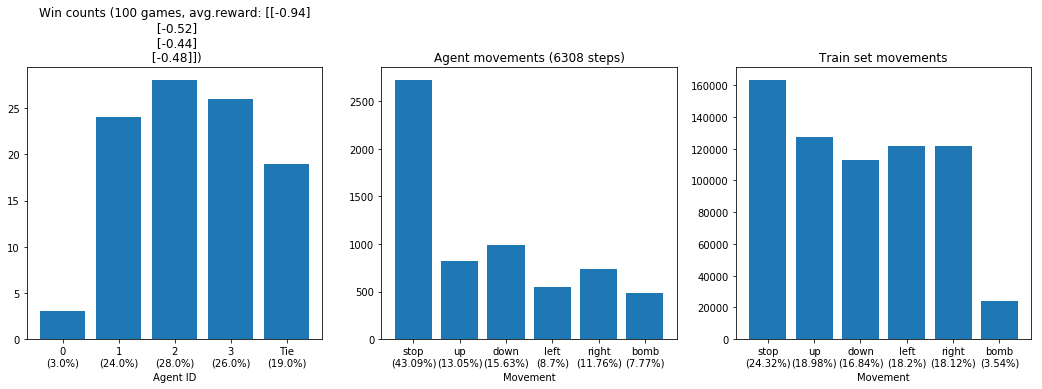

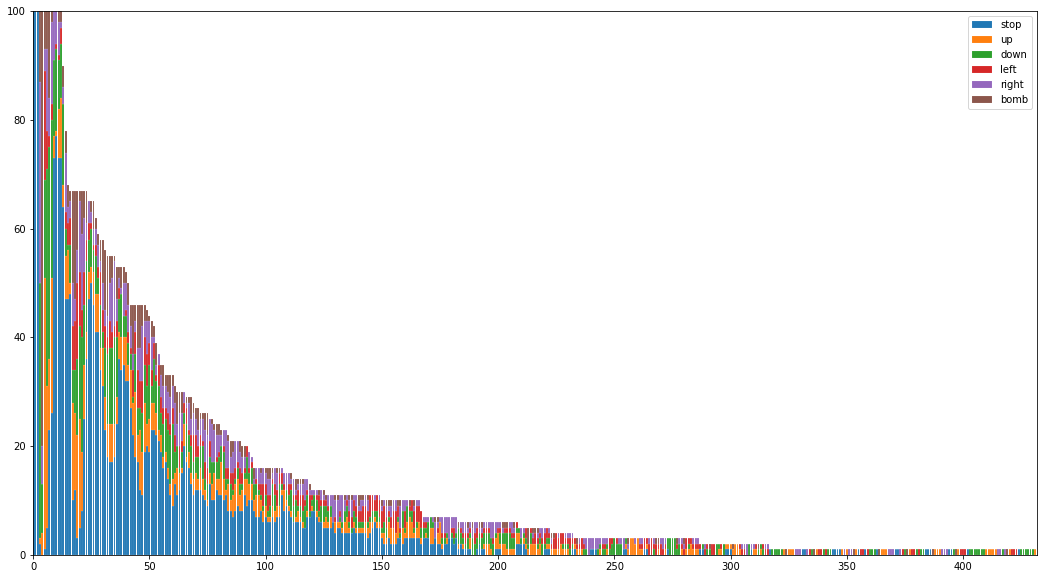

In [60]:
agent.evaluation_model = agent.pretraining_network
info, rewards, lengths, elapsed = agent.evaluate_agent(labels, iterations=100)

In [63]:
agent.pretraining_network.save('./models/dqn/' + model_name + '_full_model.hdf5')

## Reinforcement training

In [69]:
class TensorforceAgent(BaseAgent):
    def act(self, obs, action_space):
        pass
    
class TensorboardLogger(Callback):
    """Logging in tensorboard without tensorflow ops."""
    def __init__(self, log_dir):
        # Some algorithms compute multiple episodes at once since they are multi-threaded.
        # We therefore use a dictionary that is indexed by the episode to separate episodes
        # from each other.
        self.observations = {}
        self.rewards = {}
        self.actions = {}
        self.metrics = {}
        self.step = 0
        """Creates a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def log_scalar(self, tag, value, step):
        """Log a scalar variable.
        Parameter
        ----------
        tag : basestring
            Name of the scalar
        value
        step : int
            training iteration
        """
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def on_train_begin(self, logs):
        self.metrics_names = self.model.metrics_names

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []
        self.metrics[episode] = []

    def on_episode_end(self, episode, logs):
        episode_steps = len(self.observations[episode])
        variables = {
            'step': self.step,
            'nb_steps': self.params['nb_steps'],
            'episode_steps': episode_steps,
            'episode_reward': np.sum(self.rewards[episode]),
            'reward_mean': np.mean(self.rewards[episode]),
            'reward_min': np.min(self.rewards[episode]),
            'reward_max': np.max(self.rewards[episode]),
            'action_mean': np.mean(self.actions[episode]),
            'action_min': np.min(self.actions[episode]),
            'action_max': np.max(self.actions[episode]),
            'obs_mean': np.mean(self.observations[episode]),
            'obs_min': np.min(self.observations[episode]),
            'obs_max': np.max(self.observations[episode]),
        }

        # Format all metrics.
        metrics = np.array(self.metrics[episode])
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for idx, name in enumerate(self.metrics_names):
                try:
                    value = np.nanmean(metrics[:, idx])
                except Warning:
                    value = -1
                variables[name] = value
        for key, value in variables.items():
            self.log_scalar(key, value, episode + 1)

        # Free up resources.
        del self.observations[episode]
        del self.rewards[episode]
        del self.actions[episode]
        del self.metrics[episode]

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])
        self.metrics[episode].append(logs['metrics'])
        self.step += 1

Redefine environment wrapper for the reinforcement

In [70]:
class EnvWrapper(Env):
    """The abstract environment class that is used by all agents. This class has the exact
        same API that OpenAI Gym uses so that integrating with it is trivial. In contrast to the
        OpenAI Gym implementation, this class only defines the abstract methods without any actual
        implementation.
        To implement your own environment, you need to define the following methods:
        - `step`
        - `reset`
        - `render`
        - `close`
        Refer to the [Gym documentation](https://gym.openai.com/docs/#environments).
        """
    reward_range = (-1, 1)
    action_space = None
    observation_space = None

    def __init__(self, gym, board_size):
        self.gym = gym
        self.action_space = gym.action_space
        self.observation_space = gym.observation_space
        self.reward_range = gym.reward_range
        self.board_size = board_size
#         self.observations_history = []
#         self.step = 0
        
#     def make_observation(self, obs, i):
#         if i == 0: # If it is a first observation
#             return np.array([obs for _ in range(history_length)])
#         elif i < 3: # If there are less than 3 observations in a history
#             n_first = 3 - i
#             return np.concatenate([np.array([self.observations_history[0] for _ in range(n_first)]), # Repeat the first observation
#                                    np.array(self.observations_history[:i]).reshape(i, view_size, view_size, n_channels), # Add next observations
#                                    obs.reshape(1, view_size, view_size, n_channels)], # Current observation
#                                    axis=0)
#         else:
#             return np.concatenate([np.array(self.observations_history[i-history_length+1:i]).reshape(history_length-1, view_size, view_size, n_channels), # Add next observations
#                                    obs.reshape(1, view_size, view_size, n_channels)], # Current observation
#                                    axis=0)

    def step(self, action):
        """Run one timestep of the environment's dynamics.
        Accepts an action and returns a tuple (observation, reward, done, info).
        # Arguments
            action (object): An action provided by the environment.
        # Returns
            observation (object): Agent's observation of the current environment.
            reward (float) : Amount of reward returned after previous action.
            done (boolean): Whether the episode has ended, in which case further step() calls will return undefined results.
            info (dict): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """
        obs = self.gym.get_observations()
        all_actions = self.gym.act(obs)
        all_actions.insert(self.gym.training_agent, action)
        state, reward, terminal, info = self.gym.step(all_actions)
        agent_state = self.featurize(state[self.gym.training_agent])
        
#         agent_state_history = self.make_observation(agent_state, self.step)
        agent_reward = reward[self.gym.training_agent]
        
#         self.step += 1
        return agent_state, agent_reward, terminal, info

    def reset(self):
        """
        Resets the state of the environment and returns an initial observation.
        # Returns
            observation (object): The initial observation of the space. Initial reward is assumed to be 0.
        """
        obs = self.gym.reset()
#         self.step = 1
        agent_obs = self.featurize(obs[self.gym.training_agent])
#         self.observations_history = [agent_obs]
        return agent_obs

    def render(self, mode='human', close=False):
        """Renders the environment.
        The set of supported modes varies per environment. (And some
        environments do not support rendering at all.)
        # Arguments
            mode (str): The mode to render with.
            close (bool): Close all open renderings.
        """
        self.gym.render(mode=mode, close=close)

    def close(self):
        """Override in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        self.gym.close()

    def seed(self, seed=None):
        """Sets the seed for this env's random number generator(s).
        # Returns
            Returns the list of seeds used in this env's random number generators
        """
        raise self.gym.seed(seed)

    def configure(self, *args, **kwargs):
        """Provides runtime configuration to the environment.
        This configuration should consist of data that tells your
        environment how to run (such as an address of a remote server,
        or path to your ImageNet data). It should not affect the
        semantics of the environment.
        """
        raise NotImplementedError()

    def featurize(self, obs):
        return featurize(obs, center=True, crop=False)

    def __del__(self):
        self.close()

    def __str__(self):
        return '<{} instance>'.format(type(self).__name__)


class CustomProcessor(Processor):
    def process_state_batch(self, batch):
        """Processes an entire batch of states and returns it.
        # Arguments
            batch (list): List of states
        # Returns
            Processed list of states
        """
#         batch = np.squeeze(batch, axis=1)
        batch = np.array([np.concatenate(obs, axis=-1) for obs in batch])
        return batch

    def process_info(self, info):
        """Processes the info as obtained from the environment for use in an agent and
        returns it.
        """
        info['result'] = info['result'].value
        return info

### Train the model

In [116]:
agent.load_weights()

Trying to load weights
Weights were loaded successful


In [72]:
def get_env(agent_id=0):
    # Instantiate the environment
    config = ffa_v0_env()
    env = Pomme(**config["env_kwargs"])

    np.random.seed(0)
    env.seed(0)
    # Add 3 random agents and one Tensorforce
    agents = [TensorforceAgent(config["agent"](agent_id, config["game_type"])) if i == agent_id else SimpleAgent(config["agent"](i, config["game_type"])) for i in range(4)]
    env.set_agents(agents)
    env.set_training_agent(agents[agent_id].agent_id)
    env.set_init_game_state(None)
    
    return env

In [110]:
def get_dqn(model,
            log_interval=100000,
            model_name='deep_mind_dqn_rl_2d_1',
            file_log_path='./logs/dqn/rl_2d/log.txt',
            tensorboard_path='./logs/dqn/rl_2d/'):
    
    model_path = './models/dqn/' + model_name + '.h5'
    file_logger = FileLogger(file_log_path, interval=log_interval)
    checkpoint = ModelIntervalCheckpoint(model_path, interval=log_interval)
    tensorboard = TensorboardLogger(tensorboard_path)
    callbacks=[file_logger, checkpoint, tensorboard]

    # We use 4 last observations
    memory=SequentialMemory(limit=500000, window_length=history_length)

    # Select a policy. We use eps-greedy action selection, which means that a random action is selected
    # with probability eps. We anneal eps from 1.0 to 0.1 over the course of 1M steps. This is done so that
    # the agent initially explores the environment (high eps) and then gradually sticks to what it knows
    # (low eps). We also set a dedicated eps value that is used during testing. Note that we set it to 0.05
    # so that the agent still performs some random actions. This ensures that the agent cannot get stuck.
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                                  nb_steps=1000000)
    #policy=BoltzmannQPolicy()

    # enable the dueling network
    # you can specify the dueling_type to one of {'avg','max','naive'}
    dqn = DQNAgent(model=model, 
                   nb_actions=env.action_space.n, 
                   memory=memory, 
                   policy=policy,
                   processor=CustomProcessor(),
                   nb_steps_warmup=512,
                   enable_dueling_network=True, 
                   dueling_type='avg', 
                   target_model_update=5e2,  
                   batch_size=32)

    dqn.compile(Adam(lr=5e-4), metrics=['mae'])
    
    return dqn, callbacks

In [96]:
dqn, callbacks = get_dqn(agent.rl_network)

In [97]:
env_wrapper = EnvWrapper(get_env(agent_id=0), BOARD_SIZE)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
history = dqn.fit(env_wrapper, nb_steps=5e6, visualize=False, verbose=2,
                  nb_max_episode_steps=env._max_steps,
                  callbacks=callbacks)

In [113]:
dqn.model.save('./models/dqn/deep_mind_dqn_rl_2d_8_1M_full_model.hdf5')

## Reward shaping

We will continue the training with the reward shaping

In [117]:
def isBetween(a, b, c):
    crossproduct = (c.y - a.y) * (b.x - a.x) - (c.x - a.x) * (b.y - a.y)
    epsilon = 0.0001
    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) > epsilon:
        return False

    dotproduct = (c.x - a.x) * (b.x - a.x) + (c.y - a.y)*(b.y - a.y)
    if dotproduct < 0:
        return False

    squaredlengthba = (b.x - a.x)*(b.x - a.x) + (b.y - a.y)*(b.y - a.y)
    if dotproduct > squaredlengthba:
        return False

    return True

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def scale(self, s):
        self.x *= s
        self.y *= s
        return self
# Test
# A = Point(0,0)
# B = Point(5,5)
# C = Point(2,2.0001)

# isBetween(A,B,C)

class RewardShaping:
    """ It takes care of everything just add in the environment loop and make
        sure that you reset it either by creating a new calling reset at the end
        of each episode otherwise last observation from prev episode is used which
        can raise some errors!
    """
    def __init__(self, obs_prev = None, action_prev = None):
        self.reset(obs_prev, action_prev)
        
    def reset(self, obs_prev = None, action_prev = None):
        self.obs_prev = obs_prev
        self.action_prev = action_prev
        # for debug purpose
        self.obs_cur = None
        self.action_cur = None
        self.conseqActionCounter = 0
        self.dist2bombs_prev = 0
        self.notUsingAmmoCount = 0
        # catch enemy
        self.closestEnemyIdPrev = -1
        self.closestEnemyDistPrev = float("inf")
        
    def shape_it(self, obs_now, action_now, reward):
        """ Shape the reward based on the current and previous observation
            input: current observation, current action, and received reward
            output: the shaped reward, sum of each criteria for the final reward
        """
        self.obs_cur = obs_now
        self.action_cur = action_now
        if reward == -1 or reward == 1: # nothing to do with won/lost agent reward
            return reward, None
        #
        if self.obs_prev is None:
            #print("first iteration")
            self.obs_prev = obs_now
            self.action_prev = action_now
            return reward, None
        #
        reward_tmp = {}
        # REWARD VALUES (NB: some of them used as factors not directly!)
        MOBILITY_RWRD = 0.1
#         CONSEQ_ACT_RWRD = -0.5
        CONSEQ_ACT_RWRD = -0.0001
        
        PLNT_BOMB_NEAR_WOOD_RWRD = 0.05
        PLNT_BOMB_NEAR_ENEM_RWRD = 0.1
#         ON_FLAMES_RWRD = -0.8
        ON_FLAMES_RWRD = -0.0001
        
        INCRS_DIST_WITH_BOMBS_RWRD = 0.05
        PICKED_POWER_RWRD = 0.1
#         CATCH_ENEMY_RWRD = 0.1
        CATCH_ENEMY_RWRD = 0.001
        #
        # movement: + for mobility
        pose_t = np.array(obs_now['position']) # t
        pose_tm1 = np.array(self.obs_prev['position']) # t-1
        moveDist = np.linalg.norm(pose_t-pose_tm1)
        reward_tmp['mobility'] = MOBILITY_RWRD if moveDist > 0 else 0 # give reward
        #
        # consequative action: - for conseq actions
        if self.action_prev == action_now:
            self.conseqActionCounter += 1
        else:
            self.conseqActionCounter = 0
        if self.conseqActionCounter > 11:
            reward_tmp['conseqact'] = CONSEQ_ACT_RWRD
        # keeping ammo: - for not using its ammo
        if obs_now['ammo'] == self.obs_prev['ammo']:
            self.notUsingAmmoCount += 1
        else:
            self.notUsingAmmoCount = 0
        if self.notUsingAmmoCount > 11:
            reward_tmp['ammousage'] = CONSEQ_ACT_RWRD
        #
        # plant a bomb: + based on value of the bombing position
        bombs_pose = np.argwhere(obs_now['bomb_life'] != 0)
        if obs_now['ammo'] < self.obs_prev['ammo']:
            surroundings = [(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0)]
            mybomb_pose = self.obs_prev['position'] # equal to agent previous position
            # validate if the bomb actually exists there
            found_the_bomb = False
            for bp in bombs_pose:
                if np.equal(bp, mybomb_pose).all():
                    found_the_bomb = True
                    break
            assert found_the_bomb # end of validation
            nr_woods = 0
            nr_enemies = 0
            for p in surroundings:
                cell_pose = (mybomb_pose[0] + p[0], mybomb_pose[1] + p[1])
                if cell_pose[0] > 10 or cell_pose[1] > 10: # bigger than board size
                    continue
                #print(obs_now['board'][cell_pose])
                nr_woods += obs_now['board'][cell_pose] == Item.Wood.value
                nr_enemies += obs_now['board'][cell_pose] in [e.value for e in obs_now['enemies']]
            #print("nr woods: ", nr_woods)
            #print("nr enemies: ", nr_enemies)
            assert nr_woods + nr_enemies < 10
            reward_tmp['plantbomb'] = \
                PLNT_BOMB_NEAR_WOOD_RWRD * nr_woods \
                + PLNT_BOMB_NEAR_ENEM_RWRD * nr_enemies # give reward
        #
        # on Flames: - if agent on any blast direction 
        for bp in bombs_pose:
            def rot_deg90cw(point):
                new_point = [0, 0]
                new_point[0] = point[1]
                new_point[1] = -point[0]
                return new_point
            
            #print(type(bp))
            factor = 1/obs_now['bomb_life'][tuple(bp)] # inverse of time left
            blast_strength = obs_now['bomb_blast_strength'][tuple(bp)]

            # blast directions
            blast_N = Point(0,1).scale(blast_strength)
            blast_S = Point(0,-1).scale(blast_strength)
            blast_W = Point(-1,0).scale(blast_strength)
            blast_E = Point(1,0).scale(blast_strength)

            # agent on blast direction?
            bpPose = rot_deg90cw(bp)
            myPose = rot_deg90cw(obs_now['position'])
            myPose = Point(myPose[0]-bpPose[0], myPose[1]-bpPose[1]) # my pose relative to the bomb!
            onBlastDirect = isBetween(blast_N, blast_S, myPose) or \
                            isBetween(blast_W, blast_E, myPose)
            if onBlastDirect:
                #print("time: ", obs_now['bomb_life'][tuple(bp)])
                #print("on blast: ", factor)
                reward_tmp['onflame'] = ON_FLAMES_RWRD * factor
        #
        # Bombs distance: + if total distance from bombs increased
        dist2bombs = 0
        for bp in bombs_pose:
            dist2bombs += np.linalg.norm(obs_now['position']-bp)
        dist_delta = dist2bombs - self.dist2bombs_prev
        self.dist2bombs_prev = dist2bombs
        #print(dist_delta)
        # TODO: this may not be good if the delta oscillates all the time
        if (dist_delta > 0 and moveDist):
            reward_tmp['bombsdistance'] = dist_delta * INCRS_DIST_WITH_BOMBS_RWRD
        # picked power: + for every picked power
        potentialPower = self.obs_prev['board'][obs_now['position']]
        picked_power = (potentialPower == Item.ExtraBomb.value) or\
                       (potentialPower == Item.IncrRange.value) or\
                       (potentialPower == Item.Kick.value)
        if picked_power:
            reward_tmp['pickedpower'] = PICKED_POWER_RWRD
        
        # catch enemy: + if closing distance with the nearest enemy
        def closestEnemy():
            myPose = obs_now['position']
            closestEnemyId = -1
            closestEnemyDist = float("inf")
            for e in obs_now['enemies']:
                enemyPose = np.argwhere(obs_now['board'] == e.value)
                if len(enemyPose) == 0:
                    continue
                dist2Enemy = np.linalg.norm(myPose-enemyPose)
                if dist2Enemy <= closestEnemyDist:
                    closestEnemyId = e.value
                    closestEnemyDist = dist2Enemy
            return closestEnemyId, closestEnemyDist

        closestEnemyId_cur, closestEnemyDist_cur = closestEnemy()
        if self.closestEnemyIdPrev != closestEnemyId_cur:
            self.closestEnemyIdPrev = closestEnemyId_cur
            self.closestEnemyDistPrev = closestEnemyDist_cur
        else:
            CATCHING_TRHE = 4 # consider catching when close at most this much to the enemy
            if closestEnemyDist_cur < self.closestEnemyDistPrev and\
                closestEnemyDist_cur < CATCHING_TRHE:
                reward_tmp['catchenemy'] = CATCH_ENEMY_RWRD
                self.closestEnemyDistPrev = closestEnemyDist_cur
            if closestEnemyDist_cur <= 1.1: # got that close
                self.closestEnemyDistPrev = float("inf")
        #print("catching: ", closestEnemyIdPrev)
        
        # update previous obs and action
        self.obs_prev = obs_now
        self.action_prev = action_now
        
        # just a notice :
        for k,v in reward_tmp.items():
            if v >= 1.0 or v <= -1.0:
                print("reward for criteria '%s' is %f" % (k, v))
        
        # sum up rewards
        reward_shaped = reward + sum(reward_tmp.values())
        return np.clip(reward_shaped, -0.9, 0.9), reward_tmp

In [118]:
class EnvWrapperRS(EnvWrapper):
    def __init__(self, gym, board_size):
        super(EnvWrapperRS, self).__init__(gym, board_size)
        self.rewardShaping = RewardShaping()
    
    def step(self, action):
        """Run one timestep of the environment's dynamics.
        Accepts an action and returns a tuple (observation, reward, done, info).
        # Arguments
            action (object): An action provided by the environment.
        # Returns
            observation (object): Agent's observation of the current environment.
            reward (float) : Amount of reward returned after previous action.
            done (boolean): Whether the episode has ended, in which case further step() calls will return undefined results.
            info (dict): Contains auxiliary diagnostic information (helpful for debugging, and sometimes learning).
        """
        obs = self.gym.get_observations()
        all_actions = self.gym.act(obs)
        all_actions.insert(self.gym.training_agent, action)
        state, reward, terminal, info = self.gym.step(all_actions)
        
        action = all_actions[self.gym.training_agent]
        agent_state = self.featurize(state[self.gym.training_agent])
        agent_reward = reward[self.gym.training_agent]
        
        agent_reward, reward_info = self.rewardShaping.shape_it(obs[self.gym.training_agent], 
                                                   action, agent_reward)
        
        return agent_state, agent_reward, terminal, info

    def reset(self):
        """
        Resets the state of the environment and returns an initial observation.
        # Returns
            observation (object): The initial observation of the space. Initial reward is assumed to be 0.
        """
        obs = self.gym.reset()
        self.rewardShaping.reset()
        agent_obs = self.featurize(obs[self.gym.training_agent])
        return agent_obs

Train

In [119]:
env_wrapper = EnvWrapperRS(get_env(agent_id=0), BOARD_SIZE)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [120]:
dqn_rs, callbacks = get_dqn(agent.rl_network,
                 model_name='deep_mind_dqn_rl_2d_rs2_1',
                 file_log_path='./logs/dqn/rl_2d_rs2/log.txt',
                 tensorboard_path='./logs/dqn/rl_2d_rs2/')

In [112]:
# We may want to continue the previous training
# dqn_rs.model.load_weights('./models/dqn/deep_mind_dqn_rl_2d_8_1M.h5')

In [ ]:
history = dqn_rs.fit(env_wrapper, nb_steps=1e6, visualize=False, verbose=2,
                  nb_max_episode_steps=env._max_steps,
                  callbacks=callbacks)

In [122]:
dqn_rs.model.save('./models/dqn/deep_mind_dqn_rl_2d_700k_rs_full_model.hdf5')